In [1]:
import os
import zipfile
import tensorflow as tf
import numpy as np
# from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow.keras as keras

from glob import glob

import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras import layers
from keras import Model, Input
from keras.applications.densenet import DenseNet201

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import torchvision.models as models
%matplotlib inline
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#penyu hijau
import os
folder_path = (r'/content/drive/MyDrive/DGU_Ensemble model/Penyu_datasets/Chelonia mydas')
test = os.listdir(folder_path)
for fichier in test: 
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [4]:
#penyu lekang
import os
folder_path = (r'/content/drive/MyDrive/DGU_Ensemble model/Penyu_datasets/Lepidochelys olivacea')
test = os.listdir(folder_path)
for fichier in test: 
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [5]:
#penyu sisik
import os
folder_path = (r'/content/drive/MyDrive/DGU_Ensemble model/Penyu_datasets/Eretmochelys imbricata')
test = os.listdir(folder_path)
for fichier in test: 
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [6]:
#penyu temmpayan
import os
folder_path = (r'/content/drive/MyDrive/DGU_Ensemble model/Penyu_datasets/Caretta caretta')
test = os.listdir(folder_path)
for fichier in test: 
    if not(fichier.endswith(".jpg")):
        os.remove(os.path.join(folder_path, fichier))

In [7]:
#cek label
from pathlib import Path
image_dir = Path('/content/drive/MyDrive/DGU_Ensemble model/Penyu_datasets')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [8]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

Filepath                   Label
0  /content/drive/MyDrive/DGU_Ensemble model/Peny...  Eretmochelys imbricata
1  /content/drive/MyDrive/DGU_Ensemble model/Peny...  Eretmochelys imbricata
2  /content/drive/MyDrive/DGU_Ensemble model/Peny...          Chelonia mydas

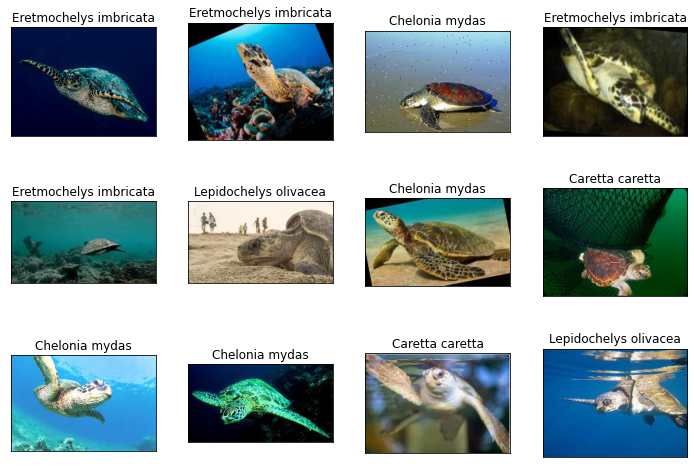

In [9]:
# Display some pictures of the dataset with their labels
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

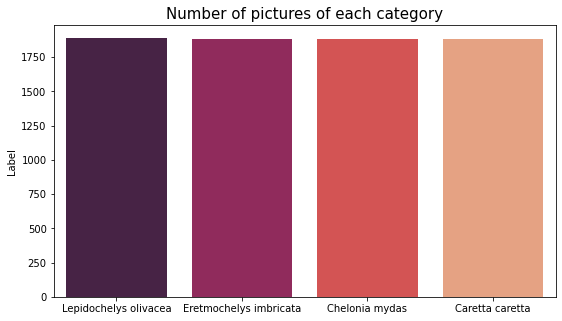

In [10]:
# Display the number of pictures of each category
import seaborn as sns
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [11]:
#Shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Separate in train 80%
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
# separate test and valid into each 10%
test_df, valid_df = train_test_split(test_df, test_size=0.67, shuffle=True, random_state=1)

In [12]:
#data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
train_data = datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=16,
                                         shuffle=True,
                                         class_mode = 'categorical',
                                        subset='training',
                                         )

val_data = val_datagen.flow_from_dataframe(dataframe=valid_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=16,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )
test_data = test_datagen.flow_from_dataframe(dataframe=test_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(224,224),
                                         batch_size=16,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )

Found 5271 validated image filenames belonging to 4 classes.
Found 1514 validated image filenames belonging to 4 classes.
Found 745 validated image filenames belonging to 4 classes.


# Model Parameter

In [13]:
batch_size = 16
EPOCHS = 100
WARMUP_EPOCHS = 2
LEARNING_RATE = 0.001
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [14]:
from keras import Model, Input
input_shape = (224,224,3)
model_input = Input(shape=input_shape)

# ** InceptionV3**


In [15]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-08-07 09:59:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   147MB/s    in 0.6s    

2022-08-07 09:59:21 (147 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = True

In [17]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [18]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


# Define Model Inceptionv3

In [19]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
IMG_SHAPE = (224, 224, 3)
base_model =tf.keras.applications.InceptionV3(weights='imagenet', 
                                       include_top=False,
                                       input_shape=IMG_SHAPE)
x =tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x =tf.keras.layers.Dropout(0.15)(x)
x =tf.keras.layers.Dense(256, activation='relu')(x)
x =tf.keras.layers.Dropout(0.15)(x)
final_output =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output')(x)
model =tf.keras.models.Model(inputs=base_model.inputs,outputs=final_output)


87924736/87910968 [==============================] - 0s 0us/step


In [20]:
for layer in model.layers: 
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 activation_107 (Activation)    (None, 25, 25, 48)   0           ['batch_normalization_107[0][0]']
                                                                                                  
 activation_110 (Activation)    (None, 25, 25, 96)   0           ['batch_normalization_110[0][0]']
                                                                                                  
 average_pooling2d_10 (AverageP  (None, 25, 25, 256)  0          ['mixed0[0][0]']                 
 ooling2D)                                                                                        
                                                                                                  
 conv2d_106 (Conv2D)            (None, 25, 25, 64)   16384       ['mixed0[0][0]']                 
                                                                                                  
 conv2d_10

In [21]:
import time

start = time.time()

STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//val_data.batch_size

history_warmup_inc = model.fit_generator(generator=train_data,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=val_data,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

end = time.time()
print('Waktu Training:', end - start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/2
329/329 [==============================] - 1806s 5s/step - loss: 0.9236 - accuracy: 0.6135 - val_loss: 0.7123 - val_accuracy: 0.7134
Epoch 2/2
329/329 [==============================] - 38s 115ms/step - loss: 0.6855 - accuracy: 0.7302 - val_loss: 0.6384 - val_accuracy: 0.7473
Waktu Training: 1868.86044383049


In [22]:
for layer in model.layers:
  layer.trainable = True

es =tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es]
optimizer =tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 activation_110 (Activation)    (None, 25, 25, 96)   0           ['batch_normalization_110[0][0]']
                                                                                                  
 average_pooling2d_10 (AverageP  (None, 25, 25, 256)  0          ['mixed0[0][0]']                 
 ooling2D)                                                                                        
                                                                                                  
 conv2d_106 (Conv2D)            (None, 25, 25, 64)   16384       ['mixed0[0][0]']                 
                                                                                                  
 conv2d_108 (Conv2D)            (None, 25, 25, 64)   76800       ['activation_107[0][0]']         
                                                                                                  
 conv2d_11

In [23]:
history_finetunning_inc = model.fit_generator(generator=train_data,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=val_data,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
329/329 [==============================] - 99s 273ms/step - loss: 1.1033 - accuracy: 0.5090 - val_loss: 2.2715 - val_accuracy: 0.3664
Epoch 2/100
329/329 [==============================] - 88s 268ms/step - loss: 0.8680 - accuracy: 0.6436 - val_loss: 1.0981 - val_accuracy: 0.6290
Epoch 3/100
329/329 [==============================] - 88s 267ms/step - loss: 0.7244 - accuracy: 0.7245 - val_loss: 1.2349 - val_accuracy: 0.6164
Epoch 4/100
329/329 [==============================] - 88s 267ms/step - loss: 0.5667 - accuracy: 0.7899 - val_loss: 1.1868 - val_accuracy: 0.6330
Epoch 5/100
329/329 [==============================] - 88s 268ms/step - loss: 0.4676 - accuracy: 0.8377 - val_loss: 0.5300 - val_accuracy: 0.7992
Epoch 6/100
329/329 [==============================] - 88s 267ms/step - loss: 0.4089 - accuracy: 0.8588 - val_loss: 1.3991 - val_accuracy: 0.5173
Epoch 7/100
329/329 [==============================] - 88s 267ms/step - loss: 0.3043 - accuracy: 0.8923 - val_loss: 0.7819 -

# ***VISUALIZE THE RESULTS  Inceptionv3 ***

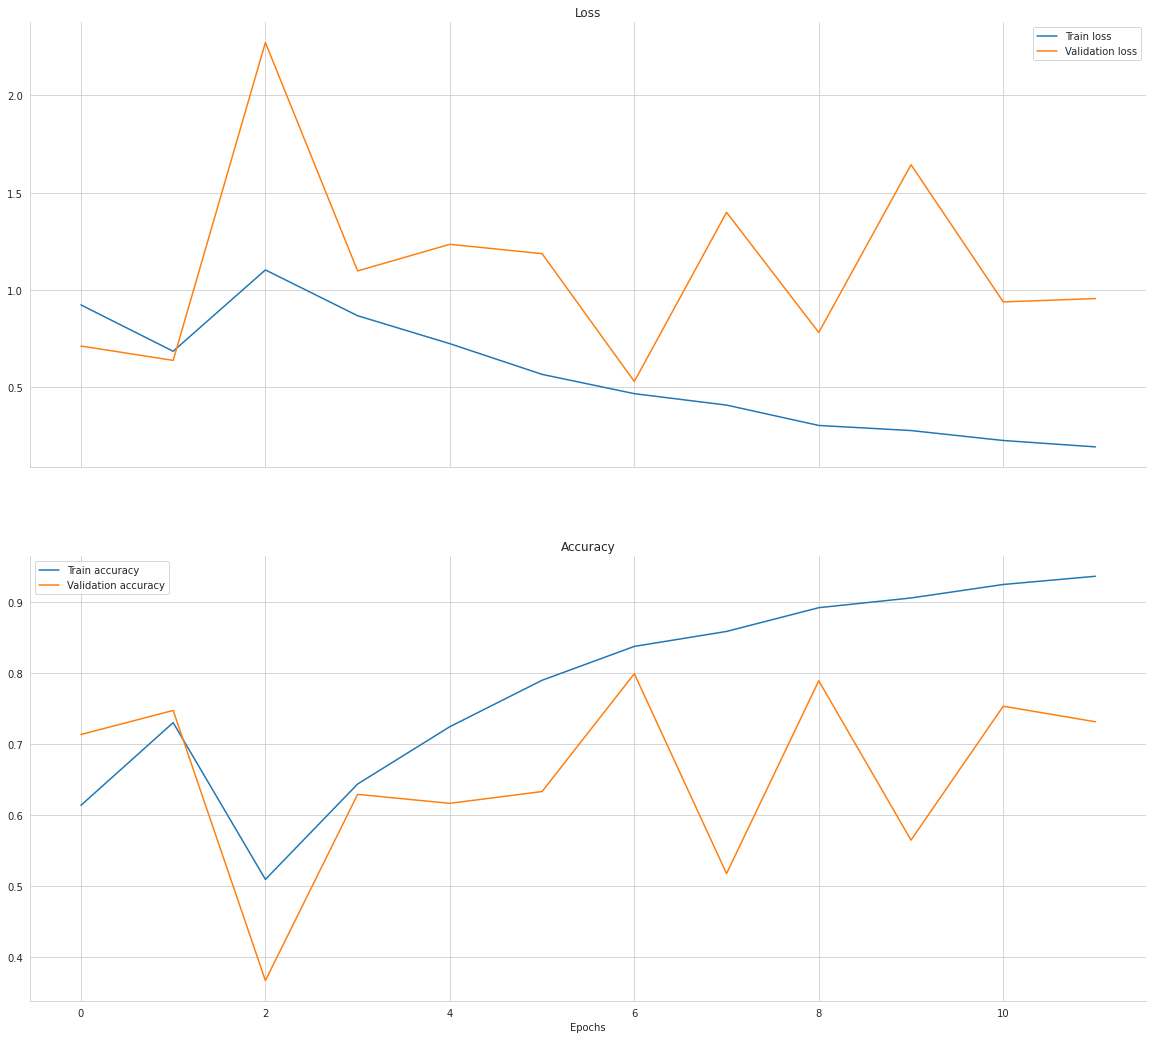

In [70]:
history_inc = {'loss': history_warmup_inc['loss'] + history_finetunning_inc['loss'], 
           'val_loss': history_warmup_inc['val_loss'] + history_finetunning_inc['val_loss'], 
           'acc': history_warmup_inc['accuracy'] + history_finetunning_inc['accuracy'], 
           'val_acc': history_warmup_inc['val_accuracy'] + history_finetunning_inc['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 18))

ax1.plot(history_inc['loss'], label='Train loss')
ax1.plot(history_inc['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history_inc['acc'], label='Train accuracy')
ax2.plot(history_inc['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [71]:
# Predict the label of the test_images
import numpy as np
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:4]}')

The first 4 predictions: ['Lepidochelys olivacea', 'Lepidochelys olivacea', 'Caretta caretta', 'Caretta caretta']


In [72]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                        precision    recall  f1-score   support

       Caretta caretta       0.58      0.95      0.72       167
        Chelonia mydas       0.91      0.68      0.78       180
Eretmochelys imbricata       0.91      0.80      0.85       182
 Lepidochelys olivacea       0.91      0.74      0.82       216

              accuracy                           0.79       745
             macro avg       0.83      0.79      0.79       745
          weighted avg       0.84      0.79      0.79       745



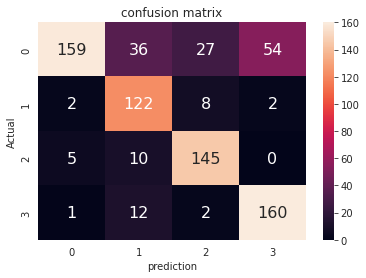

In [73]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

# DenseNet201

In [24]:
IMG_SHAPE = (224, 224, 3)
base_model_dense =tf.keras.applications.DenseNet201(weights='imagenet', 
                                       include_top=False,
                                       input_shape=IMG_SHAPE)
x_densenet =tf.keras.layers.GlobalAveragePooling2D()(base_model_dense.output)
x_densenet =tf.keras.layers.Dropout(0.15)(x_densenet)
x_densenet =tf.keras.layers.Dense(1024, activation='relu')(x_densenet)
x_densenet =tf.keras.layers.Dropout(0.15)(x_densenet)
final_output_dense =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output_dense')(x_densenet)
model_densenet201 =tf.keras.models.Model(inputs=base_model_dense.inputs,outputs=final_output_dense)

74850304/74836368 [==============================] - 0s 0us/step


In [25]:
for layer in model_densenet201.layers: 
    layer.trainable = False

for i in range(-5, 0):
    model_densenet201.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model_densenet201.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model_densenet201.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [26]:
import time

start = time.time()

STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//val_data.batch_size

history_warmup_den = model_densenet201.fit_generator(generator=train_data,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=val_data,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

end = time.time()
print('Waktu Training:', end - start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/2
329/329 [==============================] - 80s 202ms/step - loss: 0.8713 - accuracy: 0.6506 - val_loss: 0.5798 - val_accuracy: 0.7799
Epoch 2/2
329/329 [==============================] - 62s 190ms/step - loss: 0.5935 - accuracy: 0.7637 - val_loss: 0.5157 - val_accuracy: 0.8059
Waktu Training: 157.0617802143097


In [27]:
for layer in model_densenet201.layers:
  layer.trainable = True

es =tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es]
optimizer =tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model_densenet201.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model_densenet201.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv2_block4_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 56, 56, 192)  0          ['conv2_block3_concat[0][0]',    
 te)                                                              'conv2_block4_2_conv[0][0]']    
                                                                                                  
 conv2_block5_0_bn (BatchNormal  (None, 56, 56, 192)  768        ['conv2_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block5_0_relu (Activatio  (None, 56, 56, 192)  0          ['conv2_block5_0_bn[0][0]']      
 n)                                                                                               
          

In [28]:
history_finetunning_den = model_densenet201.fit(train_data,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=val_data,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/100
329/329 [==============================] - 195s 523ms/step - loss: 1.1017 - accuracy: 0.5471 - val_loss: 1.5433 - val_accuracy: 0.5273
Epoch 2/100
329/329 [==============================] - 168s 510ms/step - loss: 0.7751 - accuracy: 0.6969 - val_loss: 1.1691 - val_accuracy: 0.6523
Epoch 3/100
329/329 [==============================] - 168s 510ms/step - loss: 0.6285 - accuracy: 0.7638 - val_loss: 0.8928 - val_accuracy: 0.7148
Epoch 4/100
329/329 [==============================] - 167s 509ms/step - loss: 0.5072 - accuracy: 0.8154 - val_loss: 3.7482 - val_accuracy: 0.6057
Epoch 5/100
329/329 [==============================] - 167s 509ms/step - loss: 0.4473 - accuracy: 0.8407 - val_loss: 2.0420 - val_accuracy: 0.5938
Epoch 6/100
329/329 [==============================] - 168s 509ms/step - loss: 0.3999 - accuracy: 0.8586 - val_loss: 1.3923 - val_accuracy: 0.6363
Epoch 7/100
329/329 [==============================] - 168s 510ms/step - loss: 0.3044 - accuracy: 0.8942 - val_loss: 0

# ***VISUALIZE THE RESULTS DenseNet201***

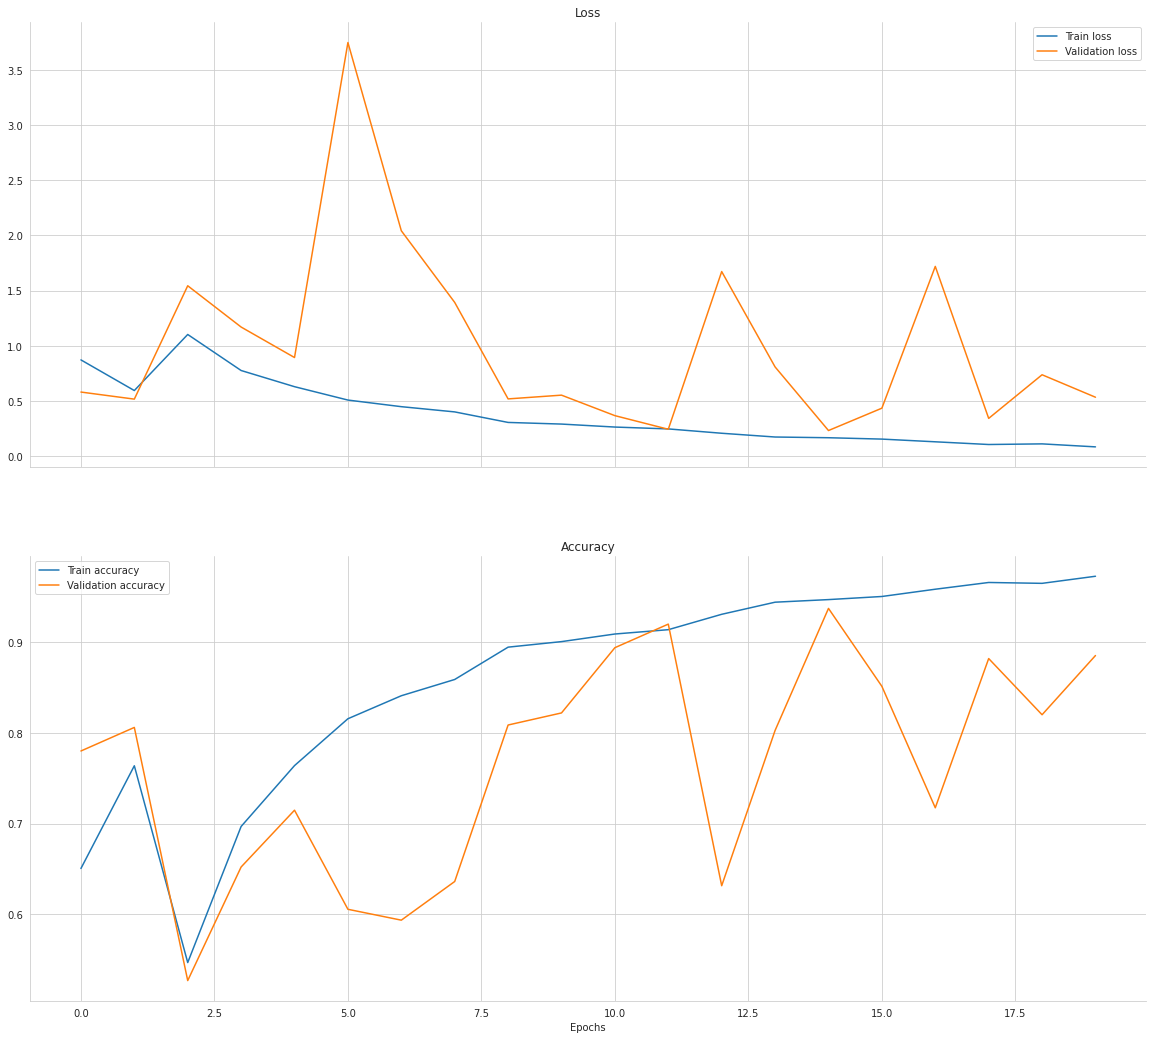

In [77]:
history_den = {'loss': history_warmup_den['loss'] + history_finetunning_den['loss'], 
           'val_loss': history_warmup_den['val_loss'] + history_finetunning_den['val_loss'], 
           'acc': history_warmup_den['accuracy'] + history_finetunning_den['accuracy'], 
           'val_acc': history_warmup_den['val_accuracy'] + history_finetunning_den['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 18))

ax1.plot(history_den['loss'], label='Train loss')
ax1.plot(history_den['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history_den['acc'], label='Train accuracy')
ax2.plot(history_den['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [74]:
# Predict the label of the test_images
import numpy as np
pred = model_densenet201.predict(test_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:4]}')

The first 4 predictions: ['Lepidochelys olivacea', 'Lepidochelys olivacea', 'Caretta caretta', 'Lepidochelys olivacea']


In [75]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                        precision    recall  f1-score   support

       Caretta caretta       0.91      0.93      0.92       167
        Chelonia mydas       0.92      0.89      0.90       180
Eretmochelys imbricata       0.96      0.90      0.93       182
 Lepidochelys olivacea       0.92      0.98      0.95       216

              accuracy                           0.93       745
             macro avg       0.93      0.92      0.92       745
          weighted avg       0.93      0.93      0.93       745



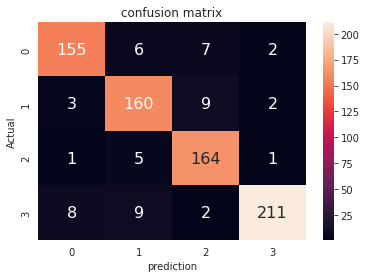

In [76]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

# `Rednet50


In [29]:
IMG_SHAPE = (224, 224, 3)
from tensorflow.keras.applications import resnet50
base_model_resnet50 =resnet50.ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_shape=IMG_SHAPE)
x_resnet50 =tf.keras.layers.GlobalAveragePooling2D()(base_model_resnet50.output)
x_resnet50 =tf.keras.layers.Dropout(0.15)(x_resnet50)
x_resnet50 =tf.keras.layers.Dense(256, activation='relu')(x_resnet50)
x_resnet50 =tf.keras.layers.Dropout(0.15)(x_resnet50)
final_output_resnet50 =tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='final_output_resnet50')(x_resnet50)
model_resnet50 =tf.keras.models.Model(inputs=base_model_resnet50.inputs,outputs=final_output_resnet50)

94781440/94765736 [==============================] - 0s 0us/step


In [30]:
for layer in model_resnet50.layers: 
    layer.trainable = False

for i in range(-5, 0):
    model_resnet50.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model_resnet50.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model_resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
          

In [31]:
import time

start = time.time()

STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//val_data.batch_size

history_warmup_r50 = model_resnet50.fit(train_data,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=val_data,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

end = time.time()
print('Waktu Training:', end - start)

Epoch 1/2
329/329 [==============================] - 49s 139ms/step - loss: 1.3951 - accuracy: 0.3199 - val_loss: 1.3131 - val_accuracy: 0.3477
Epoch 2/2
329/329 [==============================] - 45s 135ms/step - loss: 1.3139 - accuracy: 0.3500 - val_loss: 1.2893 - val_accuracy: 0.3863
Waktu Training: 167.28652477264404


In [32]:
for layer in model_resnet50.layers:
  layer.trainable = True

es =tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es]
optimizer =tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model_resnet50.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model_resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

In [33]:
history_finetunning_r50 = model_resnet50.fit(train_data,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=val_data,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/100
329/329 [==============================] - 115s 332ms/step - loss: 1.2025 - accuracy: 0.4695 - val_loss: 1.3978 - val_accuracy: 0.2414
Epoch 2/100
329/329 [==============================] - 107s 324ms/step - loss: 1.0519 - accuracy: 0.5195 - val_loss: 1.4100 - val_accuracy: 0.3411
Epoch 3/100
329/329 [==============================] - 106s 323ms/step - loss: 0.9579 - accuracy: 0.5737 - val_loss: 1.5172 - val_accuracy: 0.4195
Epoch 4/100
329/329 [==============================] - 106s 323ms/step - loss: 0.8848 - accuracy: 0.6148 - val_loss: 2.4482 - val_accuracy: 0.5126
Epoch 5/100
329/329 [==============================] - 106s 323ms/step - loss: 0.8110 - accuracy: 0.6540 - val_loss: 1.1752 - val_accuracy: 0.4840
Epoch 6/100
329/329 [==============================] - 107s 324ms/step - loss: 0.7261 - accuracy: 0.7081 - val_loss: 0.9611 - val_accuracy: 0.6323
Epoch 7/100
329/329 [==============================] - 107s 324ms/step - loss: 0.6365 - accuracy: 0.7484 - val_loss: 0

# ***VISUALIZE THE RESULTS Ensemble Resnet50***

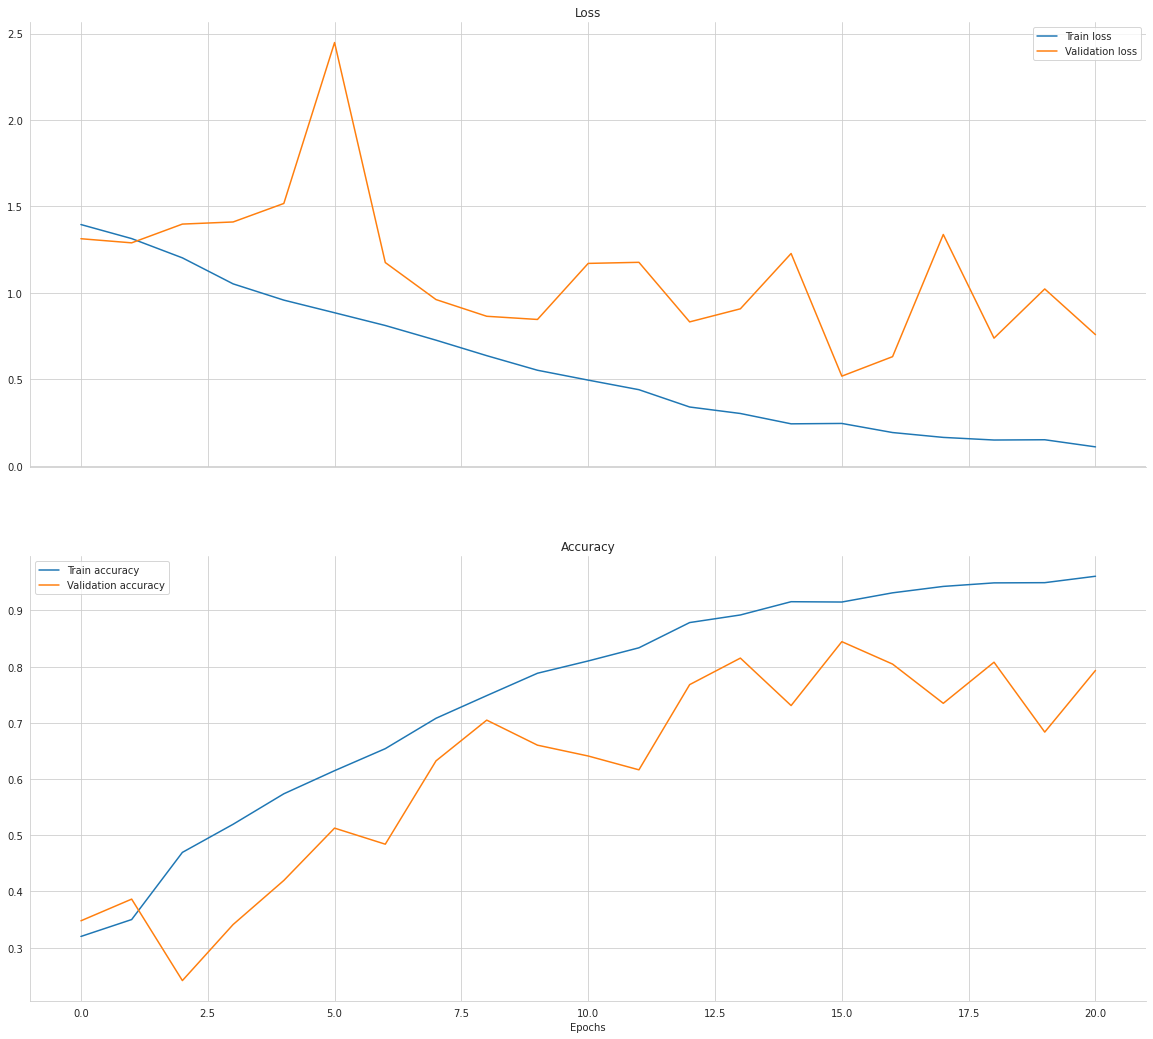

In [78]:
history_res = {'loss': history_warmup_r50['loss'] + history_finetunning_r50['loss'], 
           'val_loss': history_warmup_r50['val_loss'] + history_finetunning_r50['val_loss'], 
           'acc': history_warmup_r50['accuracy'] + history_finetunning_r50['accuracy'], 
           'val_acc': history_warmup_r50['val_accuracy'] + history_finetunning_r50['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 18))

ax1.plot(history_res['loss'], label='Train loss')
ax1.plot(history_res['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history_res['acc'], label='Train accuracy')
ax2.plot(history_res['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [82]:
# Predict the label of the test_images
import numpy as np
pred = model_resnet50.predict(test_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:4]}')

The first 4 predictions: ['Lepidochelys olivacea', 'Lepidochelys olivacea', 'Caretta caretta', 'Lepidochelys olivacea']


In [83]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                        precision    recall  f1-score   support

       Caretta caretta       0.82      0.88      0.85       167
        Chelonia mydas       0.71      0.83      0.77       180
Eretmochelys imbricata       0.92      0.73      0.82       182
 Lepidochelys olivacea       0.92      0.91      0.92       216

              accuracy                           0.84       745
             macro avg       0.85      0.84      0.84       745
          weighted avg       0.85      0.84      0.84       745



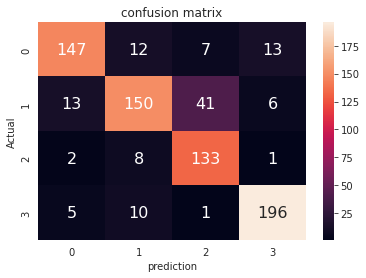

In [84]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

# Ensemble Inception & resnet50


In [34]:
models = [model, model_resnet50]
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [35]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

In [36]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Ensemble Inception & desnet201





In [37]:
models = [model, model_densenet201]
model_outputs_ID = [model(model_input) for model in models]
ensemble_output_ID = tf.keras.layers.Average()(model_outputs_ID)
ensemble_model_ID = tf.keras.Model(inputs=model_input, outputs=ensemble_output_ID)

In [38]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

In [39]:
ensemble_model_ID.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Ensemble Resnet50 & desnet201





In [40]:
models = [model, model_densenet201]
model_outputs_DR = [model(model_input) for model in models]
ensemble_output_DR = tf.keras.layers.Average()(model_outputs_DR)
ensemble_model_DR = tf.keras.Model(inputs=model_input, outputs=ensemble_output_DR)

In [41]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

In [42]:
ensemble_model_DR.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Ensemble InceptionV3, Resnet50 & DenseNet201





In [58]:
models = [model, model_densenet201, model_resnet50]
model_outputs_DRI = [model(model_input) for model in models]
ensemble_output_DRI = tf.keras.layers.Average()(model_outputs_DRI)
ensemble_model_DRI = tf.keras.Model(inputs=model_input, outputs=ensemble_output_DRI)

In [59]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

In [62]:
ensemble_model_DRI.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# ***VISUALIZE THE RESULTS Ensemble Inceptionv3 & Resnet50***

In [45]:
metrics_train = ensemble_model.evaluate(train_data)
metrics_test = ensemble_model.evaluate(test_data)

47/47 [==============================] - 190s 4s/step - loss: 0.3629 - accuracy: 0.8832


In [46]:
print(f"TRAIN_SET: {metrics_train}")
print("--------------------------------------------")
print(f"TEST_SET: {metrics_test}")

TRAIN_SET: [0.20805130898952484, 0.9548472762107849]
--------------------------------------------
TEST_SET: [0.3628903329372406, 0.883221447467804]


In [47]:
# Predict the label of the test_images
import numpy as np
pred = ensemble_model.predict(test_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:4]}')

The first 4 predictions: ['Lepidochelys olivacea', 'Lepidochelys olivacea', 'Caretta caretta', 'Lepidochelys olivacea']


In [48]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                        precision    recall  f1-score   support

       Caretta caretta       0.79      0.98      0.87       167
        Chelonia mydas       0.85      0.82      0.83       180
Eretmochelys imbricata       0.94      0.85      0.89       182
 Lepidochelys olivacea       0.96      0.90      0.93       216

              accuracy                           0.88       745
             macro avg       0.89      0.88      0.88       745
          weighted avg       0.89      0.88      0.88       745



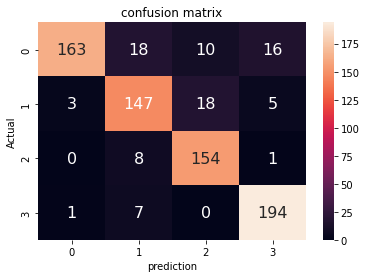

In [49]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

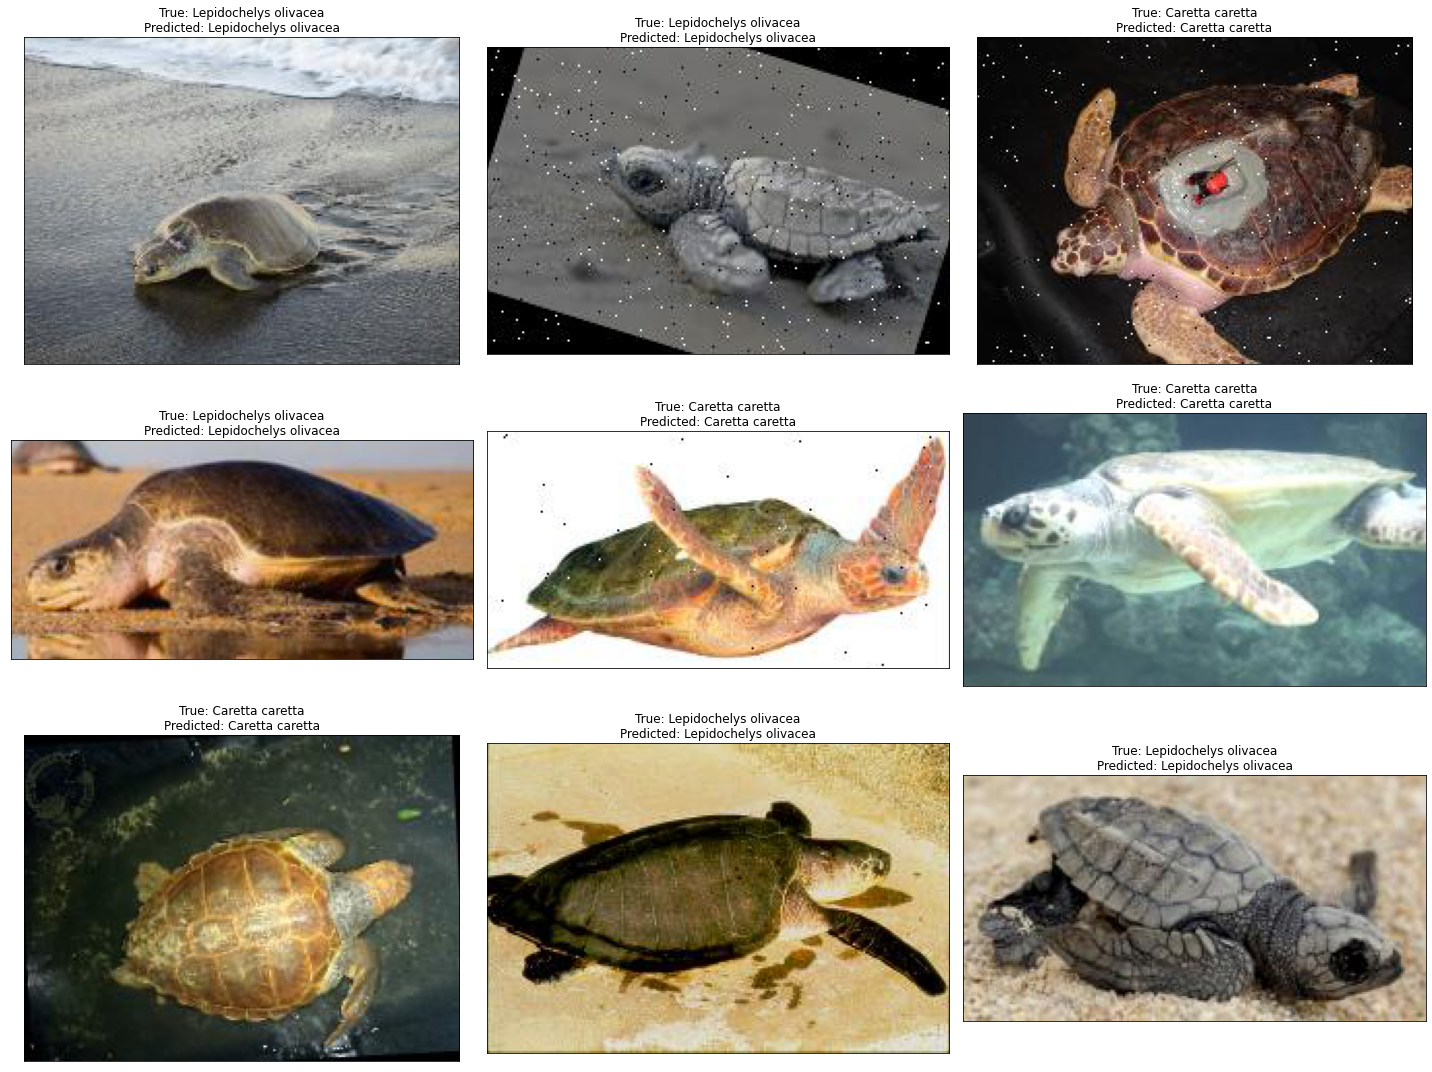

In [50]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# ***VISUALIZE THE RESULTS Ensemble Inceptionv3 & DenseNet201***

In [52]:
metrics_train = ensemble_model_ID.evaluate(train_data)
metrics_test = ensemble_model_ID.evaluate(test_data)

47/47 [==============================] - 12s 262ms/step - loss: 0.2744 - accuracy: 0.9262


In [53]:
print(f"TRAIN_SET: {metrics_train}")
print("--------------------------------------------")
print(f"TEST_SET: {metrics_test}")

TRAIN_SET: [0.16668739914894104, 0.9787516593933105]
--------------------------------------------
TEST_SET: [0.27442264556884766, 0.926174521446228]


In [54]:
# Predict the label of the test_images
import numpy as np
pred = ensemble_model_ID.predict(test_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:4]}')

The first 4 predictions: ['Lepidochelys olivacea', 'Lepidochelys olivacea', 'Caretta caretta', 'Lepidochelys olivacea']


In [55]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                        precision    recall  f1-score   support

       Caretta caretta       0.87      0.95      0.91       167
        Chelonia mydas       0.96      0.87      0.91       180
Eretmochelys imbricata       0.97      0.91      0.94       182
 Lepidochelys olivacea       0.92      0.97      0.95       216

              accuracy                           0.93       745
             macro avg       0.93      0.92      0.92       745
          weighted avg       0.93      0.93      0.93       745



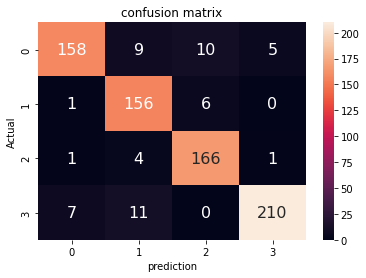

In [56]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

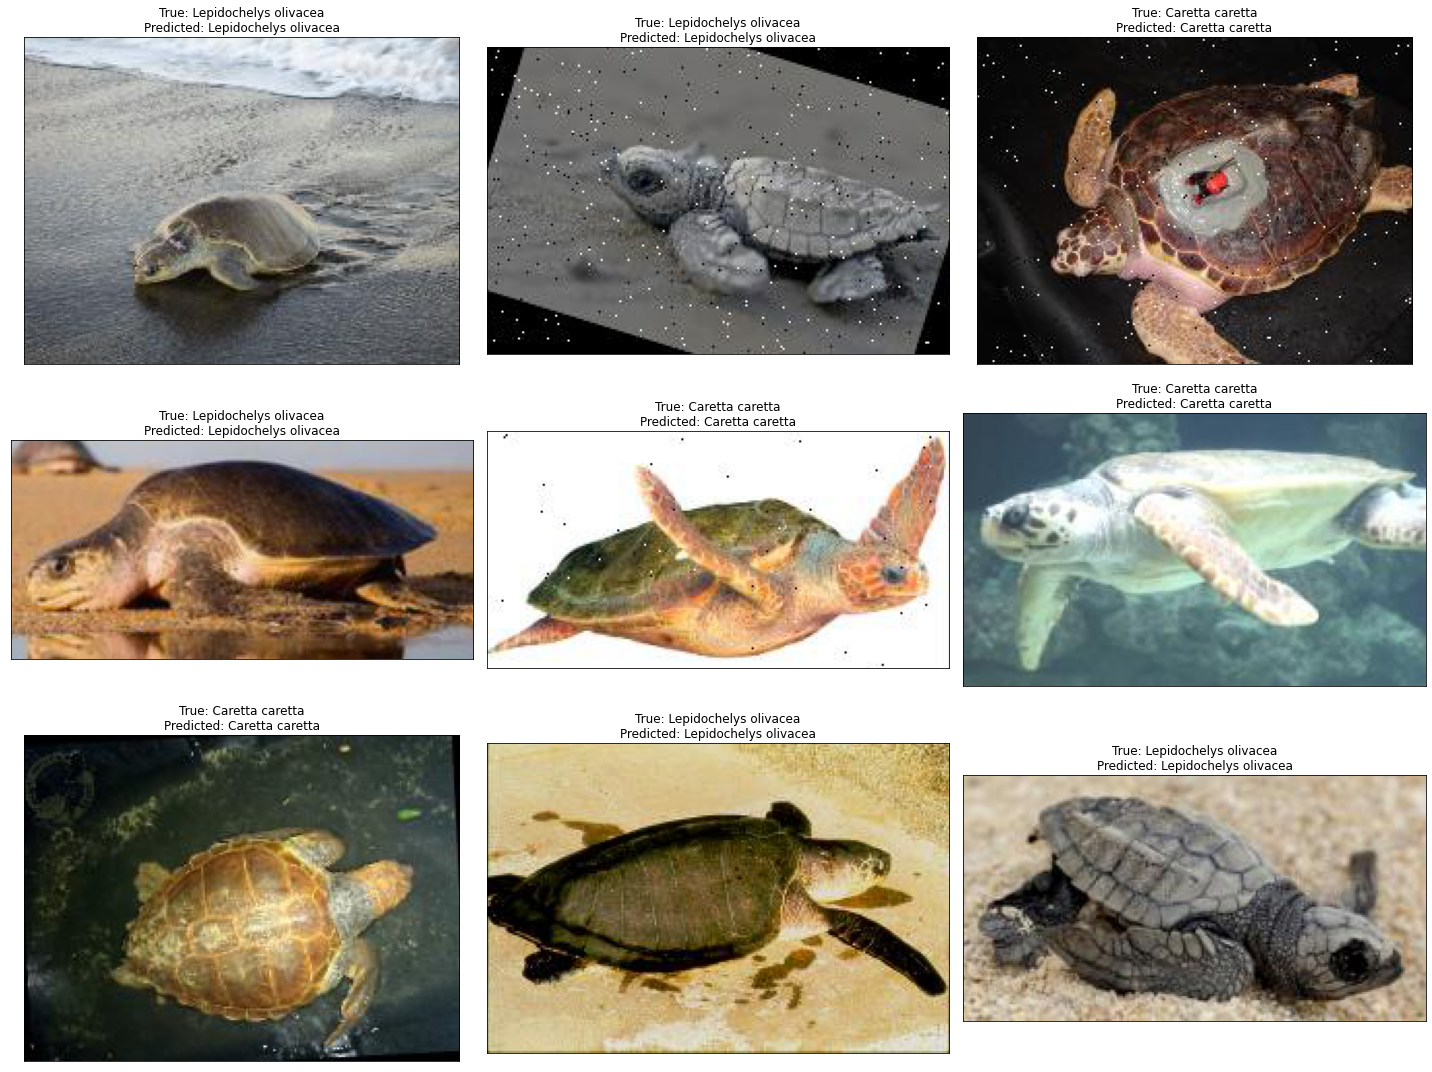

In [57]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# ***VISUALIZE THE RESULTS Ensemble Resnet50 & DenseNet201***

In [ ]:
metrics_train = ensemble_model_DR.evaluate(train_data)
metrics_test = ensemble_model_DR.evaluate(test_data)

47/47 [==============================] - 190s 4s/step - loss: 0.3629 - accuracy: 0.8832


In [ ]:
print(f"TRAIN_SET: {metrics_train}")
print("--------------------------------------------")
print(f"TEST_SET: {metrics_test}")

TRAIN_SET: [0.20805130898952484, 0.9548472762107849]
--------------------------------------------
TEST_SET: [0.3628903329372406, 0.883221447467804]


In [ ]:
# Predict the label of the test_images
import numpy as np
pred = ensemble_model_DR.predict(test_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:4]}')

The first 4 predictions: ['Lepidochelys olivacea', 'Lepidochelys olivacea', 'Caretta caretta', 'Lepidochelys olivacea']


In [ ]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                        precision    recall  f1-score   support

       Caretta caretta       0.79      0.98      0.87       167
        Chelonia mydas       0.85      0.82      0.83       180
Eretmochelys imbricata       0.94      0.85      0.89       182
 Lepidochelys olivacea       0.96      0.90      0.93       216

              accuracy                           0.88       745
             macro avg       0.89      0.88      0.88       745
          weighted avg       0.89      0.88      0.88       745



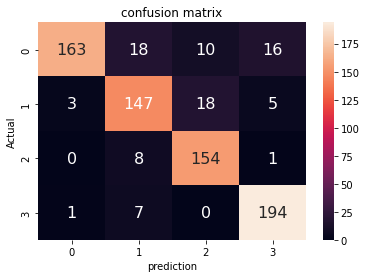

In [ ]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

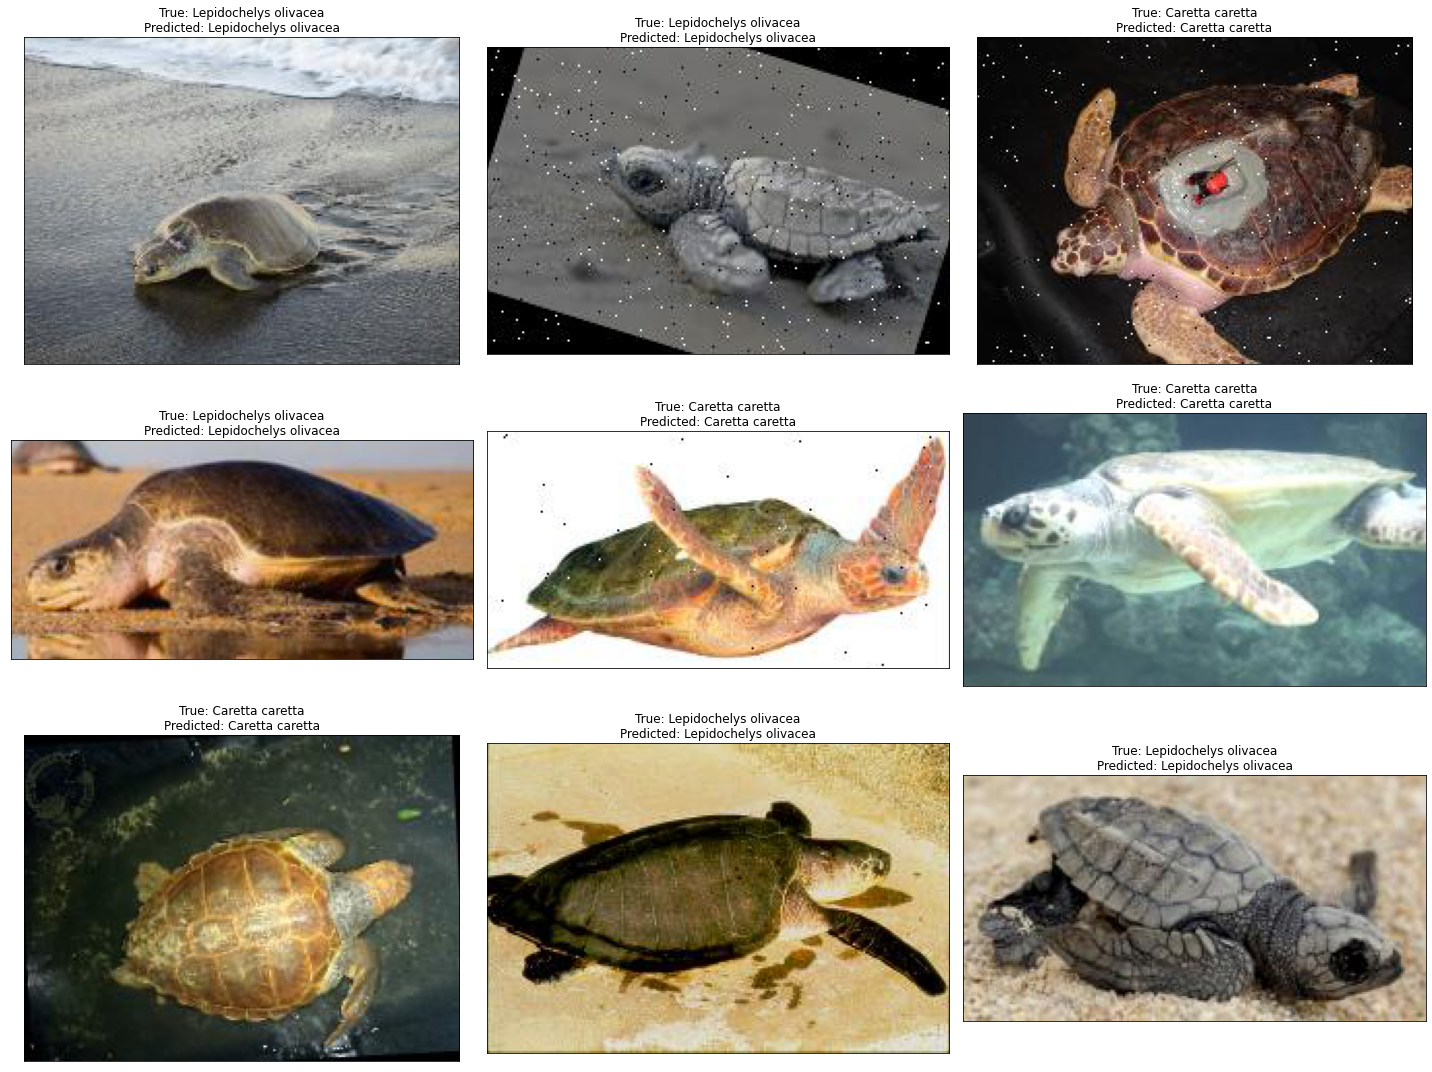

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# ***VISUALIZE THE RESULTS Ensemble Inceptionv3, Resnet50 & DenseNet201***

In [63]:
metrics_train = ensemble_model_DRI.evaluate(train_data)
metrics_test = ensemble_model_DRI.evaluate(test_data)

47/47 [==============================] - 14s 293ms/step - loss: 0.2638 - accuracy: 0.9423


In [64]:
print(f"TRAIN_SET: {metrics_train}")
print("--------------------------------------------")
print(f"TEST_SET: {metrics_test}")

TRAIN_SET: [0.1451643407344818, 0.9895655512809753]
--------------------------------------------
TEST_SET: [0.2638417184352875, 0.9422819018363953]


In [65]:
# Predict the label of the test_images
import numpy as np
pred = ensemble_model_DRI.predict(test_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 4 predictions: {pred[:4]}')

The first 4 predictions: ['Lepidochelys olivacea', 'Lepidochelys olivacea', 'Caretta caretta', 'Lepidochelys olivacea']


In [66]:
#classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                        precision    recall  f1-score   support

       Caretta caretta       0.91      0.99      0.95       167
        Chelonia mydas       0.92      0.91      0.91       180
Eretmochelys imbricata       0.98      0.91      0.94       182
 Lepidochelys olivacea       0.96      0.96      0.96       216

              accuracy                           0.94       745
             macro avg       0.94      0.94      0.94       745
          weighted avg       0.94      0.94      0.94       745



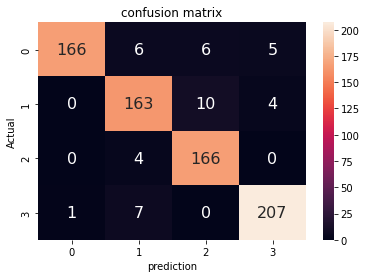

In [67]:
import seaborn as sns
import pandas as pd
cm  = confusion_matrix(pred,y_test)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

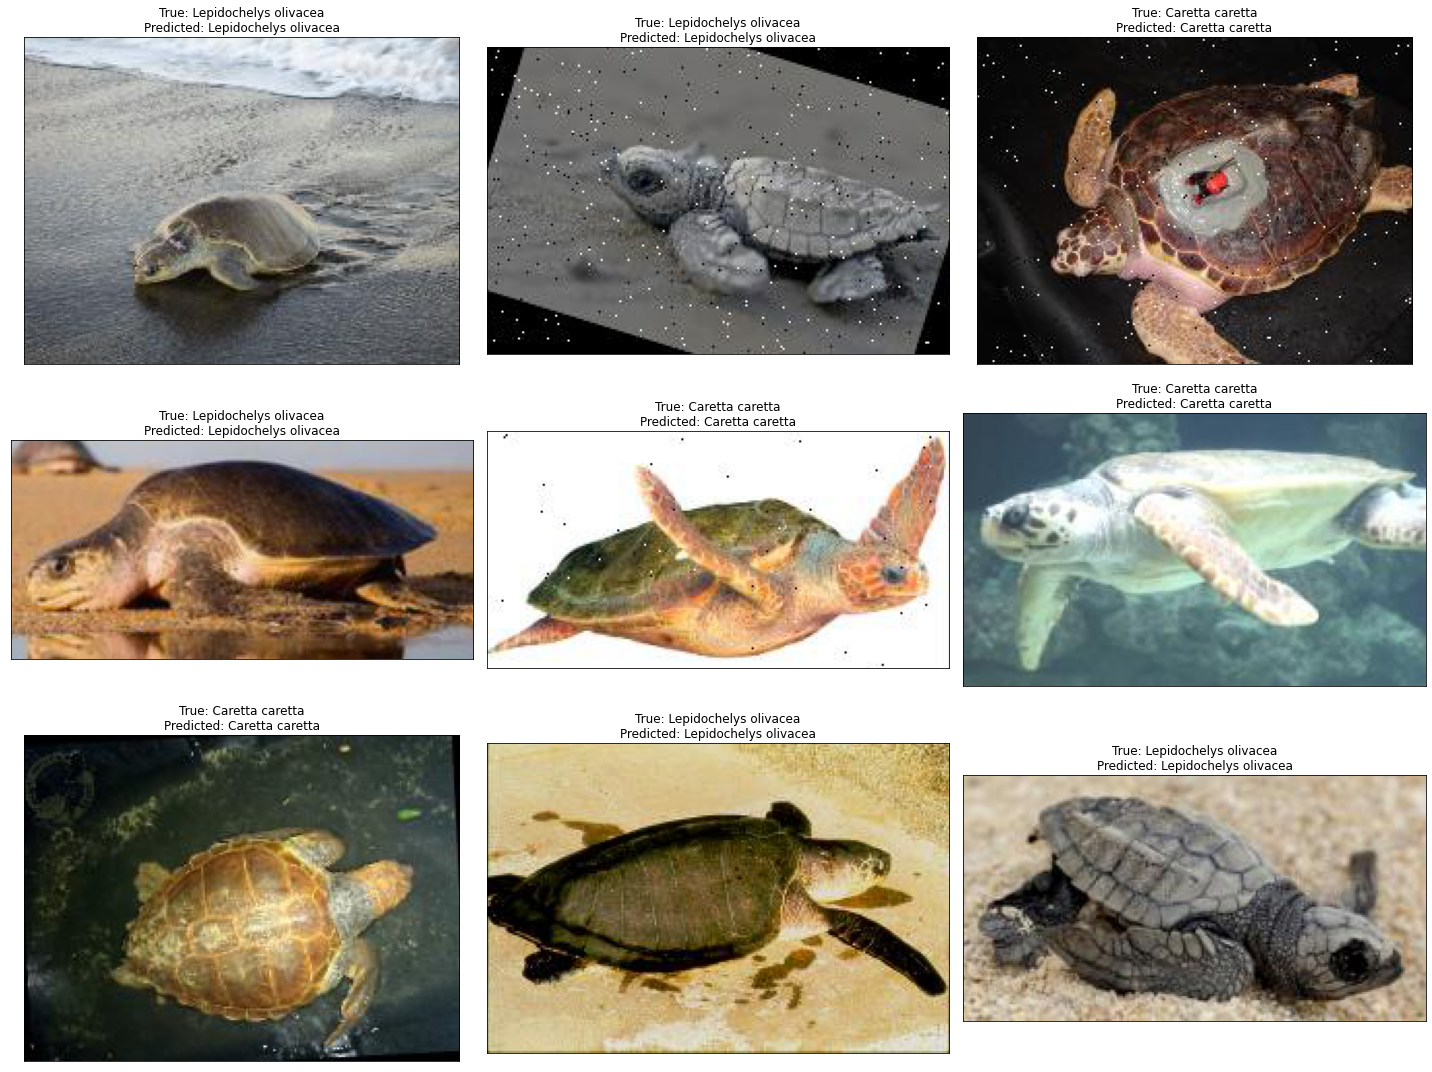

In [68]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()